# Solving PDEs with PyTorch

This file contains our first approach to solve PDEs with neural networks on the PyTorch Library.  
We will try to solve the poisson Equation :  
$-\Delta u(x) = f(x)$ on $\Omega = [0,1]^2$  
With Dirichlet homogeneous boundary conditions $u|_{\partial \Omega}=0$ and $f(x_1, x_2)=2\pi^2 sin(\pi x_1) sin(\pi x_2)$

The loss to minimize here is $\mathcal{L} = ||\Delta u(x) + f(x)||_2$, the MSE of the PDE  
The true function $u$ should be $u(x_1, x_2)=sin(\pi x_1) sin(\pi x_2)$

## Import Libraries and define constants

In [44]:
__file__ = 'C:/Users/antie/Documents/Pole_recherche/Tsunami'

In [45]:
__file__ = 'C:/Users/Gilles/CS/cours/PoleProjet/FormationRecherche/Tsunami/TP/sceance4/Tsunami'

In [46]:
#import os

#print(os.getcwd())
#os.chdir(__file__)
#print(os.getcwd())

In [47]:
import torch
import torch.nn as nn
import numpy as np
device = torch.device("cuda:0") # Specify GPU Usage for computations

In [48]:
N = 2 # Input size, corresponds to antecedent space dimension
learning_rate = 0.005 # Parameter for Adam optimizer
training_steps = 10000 # Epoch computed
report_steps = training_steps//10 # How often is the loss printed during training
grid_length = 40 # Length of the square grid considered for training

## Define neural network structure

Here we consider a perceptron with 2 hidden layers of 10 nodes, with N inputs and 1 output

In [49]:
multilayer_perceptron = nn.Sequential(
    nn.Linear(N, 30),
    nn.ReLU(),
    nn.Linear(30, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

print(multilayer_perceptron)

Sequential(
  (0): Linear(in_features=2, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=30, bias=True)
  (3): ReLU()
  (4): Linear(in_features=30, out_features=1, bias=True)
)


In [50]:
# Universal Approximator, using the paper from 1997
def g(x):
  N_x = multilayer_perceptron(x)
  A = 0
  F = 1
  return N_x*F + A

# Given EDO
def f(x):
  return x[:,0]**2+x[:,1]**2

# Loss function
loss_fct = nn.MSELoss()     
optimizer = torch.optim.Adam(multilayer_perceptron.parameters())

In [51]:
# Code taken from https://discuss.pytorch.org/t/how-to-calculate-laplacian-for-multiple-batches-in-parallel/104888
# Computes the laplacian for a batch, to use in the loss calculation

def laplace(model, x: torch.tensor):
    """
    Laplacian (= sum of 2nd derivations)
     of (evaluated) nd->1d-function fx w.r.t. nd-tensor x
    :rtype: torch.Tensor
    """
    laplacian = torch.zeros(x.shape[0]) #array to store values of laplacian

    for i, xi in enumerate(x):
        hess = torch.autograd.functional.hessian(model, xi.unsqueeze(0), create_graph=True)
        laplacian[i] = torch.diagonal(hess.view(N, N), offset=0).sum()
    
    return laplacian

## Define the grid on which to train the neural network  
We sample $\Omega = [0,1]^2$ with grid_length² uniformely distributed points

In [52]:
X = np.linspace(0, 1, grid_length)
Y = np.linspace(0, 1, grid_length)

# Put the training points and values in tensors
Z = np.array([[x,y] for x in X for y in Y])
Z_values = torch.FloatTensor(f(Z)).unsqueeze(1) # Values in tensor, unsqueeze allows to go from [10000] to [10000, 1]
Z_training = torch.FloatTensor(Z) # Points in tensor
print(Z_training)
print(Z_training.size())

tensor([[0.0000, 0.0000],
        [0.0000, 0.0256],
        [0.0000, 0.0513],
        ...,
        [1.0000, 0.9487],
        [1.0000, 0.9744],
        [1.0000, 1.0000]])
torch.Size([1600, 2])


## Train the neural network

In [53]:
multilayer_perceptron.train(True)

for epoch in range(training_steps):
    optimizer.zero_grad()   # On réinitialise les gradients entre chaque epoch

    Z_out = multilayer_perceptron(Z_training)   # Output du réseau de neurones
    #loss = loss_fct(-1*laplace(multilayer_perceptron, Z_training).unsqueeze(1), Z_values)    # On calcule la loss nécéssaire
    loss=loss_fct(Z_out,Z_values)
    loss.backward()

    optimizer.step()
    
    if epoch%report_steps==report_steps-1:
        print("Epoch n°{}: ".format(epoch+1), loss.item())
    print("Epoch n°{}: ".format(epoch+1), loss.item())

    
multilayer_perceptron.train(False)

Epoch n°1:  0.6132310032844543
Epoch n°2:  0.5951537489891052
Epoch n°3:  0.5774749517440796
Epoch n°4:  0.5601757168769836
Epoch n°5:  0.5432283878326416
Epoch n°6:  0.5265898108482361
Epoch n°7:  0.5102105140686035
Epoch n°8:  0.49409785866737366
Epoch n°9:  0.4782538115978241
Epoch n°10:  0.46272268891334534
Epoch n°11:  0.4475453197956085
Epoch n°12:  0.43273013830184937
Epoch n°13:  0.4182898700237274
Epoch n°14:  0.4042196571826935
Epoch n°15:  0.3905121088027954
Epoch n°16:  0.37720340490341187
Epoch n°17:  0.36433666944503784
Epoch n°18:  0.351901650428772
Epoch n°19:  0.33988064527511597
Epoch n°20:  0.32826077938079834
Epoch n°21:  0.3170270025730133
Epoch n°22:  0.3061601221561432
Epoch n°23:  0.29566916823387146
Epoch n°24:  0.28555095195770264
Epoch n°25:  0.2757956385612488
Epoch n°26:  0.26637935638427734
Epoch n°27:  0.2572832405567169
Epoch n°28:  0.24849136173725128
Epoch n°29:  0.2399902194738388
Epoch n°30:  0.23176831007003784
Epoch n°31:  0.2238212525844574
Epoch 

Sequential(
  (0): Linear(in_features=2, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=30, bias=True)
  (3): ReLU()
  (4): Linear(in_features=30, out_features=1, bias=True)
)

## Display results

In [54]:
import matplotlib.pyplot as plt

# Random sampling of points on which to display the approximated function
X_noise = X + (np.random.rand(grid_length)-0.5)/grid_length
Y_noise = Y + (np.random.rand(grid_length)-0.5)/grid_length
Z_validation = multilayer_perceptron(torch.FloatTensor(np.array([[x,y] for x in X for y in Y])))

(0.0, 40.0, 0.0, 40.0)

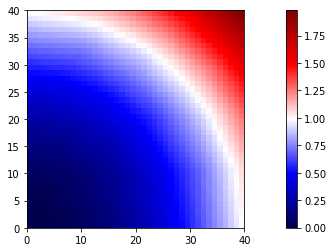

In [55]:
plt.pcolormesh(torch.reshape(Z_validation, (grid_length, grid_length)).detach().numpy(), cmap="seismic")
plt.colorbar()
plt.axis("square")

In [56]:
"""
Error with respect to true function
"""
plt.figure()

Z_out=torch(multilayer_perceptron(X_noise))

error = torch.abs(Z_validation - Z_values/(2*np.pi**2))
plt.pcolormesh(torch.reshape(error, (grid_length, grid_length)).detach().numpy(), cmap="seismic")
plt.colorbar()
plt.axis("square")

TypeError: linear(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

<Figure size 432x288 with 0 Axes>